## Data Loading

In [1]:
import os
import pandas as pd
import numpy as np
import collections
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, auc
from mxnet import gluon


import time, re
import multiprocessing as mp
import itertools
from tqdm import tqdm, tqdm_notebook
import mxnet as mx
import spacy
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [2]:
MAX_SENTENCE_LENGTH = 20
MAX_VOCAB = 10000

### Preprocessing using Spacy

In [3]:
nlp = spacy.load("en")

word_freq = collections.Counter()
max_len = 0
num_rec = 0
print('Count words and build vocab...')
with open('../data/umich-sentiment-train.txt', 'rb') as f:
    for line in f:
        _lab, _sen = line.decode('utf8').strip().split('\t')
        words = [token.lemma_ for token in nlp(_sen) if token.is_alpha] # Stop word제거 안한 상태 
        # 제거를 위해 [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
        if len(words) > max_len:
            max_len = len(words)
        for word in words:
            word_freq[word] += 1
        num_rec += 1

# most_common output -> list
word2idx = {x[0]: i+2 for i, x in enumerate(word_freq.most_common(MAX_VOCAB - 2))}
word2idx ['PAD'] = 0
word2idx['UNK'] = 1

idx2word= {i:v for v, i in word2idx.items()}
vocab_size = len(word2idx)

print('Prepare data...')
y = []
x = []
origin_txt = []
with open('../data/umich-sentiment-train.txt', 'rb') as f:
    for line in f:
        _label, _sen = line.decode('utf8').strip().split('\t')
        origin_txt.append(_sen)
        y.append(int(_label))
        words = [token.lemma_ for token in nlp(_sen) if token.is_alpha] # Stop word제거 안한 상태
        words = [x for x in words if x != '-PRON-'] # '-PRON-' 제거
        _seq = []
        for word in words:
            if word in word2idx.keys():
                _seq.append(word2idx[word])
            else:
                _seq.append(word2idx['UNK'])
        if len(_seq) < MAX_SENTENCE_LENGTH:
            _seq.extend([0] * ((MAX_SENTENCE_LENGTH) - len(_seq)))
        else:
            _seq = _seq[:MAX_SENTENCE_LENGTH]
        x.append(_seq)

pd.DataFrame(y, columns = ['yn']).reset_index().groupby('yn').count().reset_index()

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


Count words and build vocab...
Prepare data...


,yn,index
0,0,3091
1,1,3995


In [4]:
## Data process - tr/va split and define iterator

tr_idx = np.random.choice(range(len(x)), int(len(x) * .8))
va_idx = [x for x in range(len(x)) if x not in tr_idx]

tr_x = [x[i] for i in tr_idx]
tr_y = [y[i] for i in tr_idx]
tr_origin = [origin_txt[i] for i in tr_idx]

va_x = [x[i] for i in va_idx]
va_y = [y[i] for i in va_idx]
va_origin = [origin_txt[i] for i in va_idx]

batch_size = 16

learning_rate = .0002
log_interval = 100


train_data = mx.io.NDArrayIter(data=[tr_x, tr_y], batch_size=batch_size, shuffle = False)
valid_data = mx.io.NDArrayIter(data=[va_x, va_y], batch_size=batch_size, shuffle = False)

In [5]:
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, rnn
from mxnet.ndarray.linalg import gemm2
import mxnet as mx
context = mx.gpu()

#### Sentence Representation

In [6]:
class Sentence_Representation(nn.Block):
    def __init__(self, **kwargs):
        super(Sentence_Representation, self).__init__()
        for (k, v) in kwargs.items():
            setattr(self, k, v)
        
        with self.name_scope():
            self.embed = nn.Embedding(self.vocab_size, self.emb_dim)
            self.drop = nn.Dropout(.2)
            self.bi_rnn = rnn.BidirectionalCell(
                 rnn.LSTMCell(hidden_size = self.hidden_dim // 2),  #mx.rnn.LSTMCell doesnot work
                 rnn.LSTMCell(hidden_size = self.hidden_dim // 2)
            )
            self.w_1 = nn.Dense(self.d, use_bias = False)
            self.w_2 = nn.Dense(self.r, use_bias = False)

    def forward(self, x, hidden):
        embeds = self.embed(x) # batch * time step * embedding
        h, _ = self.bi_rnn.unroll(length = embeds.shape[1] \
                                       , inputs = embeds \
                                       , layout = 'NTC' \
                                       , merge_outputs = True)
        # For understanding
        batch_size, time_step, _ = h.shape
        # get self-attention
        _h = h.reshape((-1, self.hidden_dim))
        _w = nd.tanh(self.w_1(_h))
        w = self.w_2(_w)
        _att = w.reshape((-1, time_step, self.r)) # Batch * Timestep * r
        att = nd.softmax(_att, axis = 1)
        x = gemm2(att, h, transpose_a = True)  # h = Batch * Timestep * (2 * hidden_dim), a = Batch * Timestep * r
        return x, att

#### Classifier

In [7]:
classifier = nn.Sequential()
classifier.add(nn.Dense(16, activation = 'relu'))
classifier.add(nn.Dense(8, activation = 'relu'))
classifier.add(nn.Dense(1))
classifier.collect_params().initialize(mx.init.Xavier(), ctx = context)

#### Sentiment analysis classifier

In [8]:
class SA_SA_Classifier(nn.Block):
    def __init__(self, sen_rep, classifier, context, **kwargs):
        super(SA_SA_Classifier, self).__init__(**kwargs)
        self.context = context
        with self.name_scope():
            self.sen_rep = sen_rep
            self.classifier = classifier
            
    def forward(self, x):
        # Initial hidden state
        hidden = self.sen_rep.bi_rnn.begin_state()

        # sentence representation할 때 hidden의 context가 cpu여서 오류 발생. context를 gpu로 전환
        lstm_out, att = self.sen_rep(x, hidden)
        x = nd.flatten(lstm_out)
        res = self.classifier(x)
        return res, att         

In [9]:
emb_dim = 100 # Emb dim
hidden_dim = 20 # Hidden dim for LSTM

#### Initiate sentiment classifier

In [10]:
emb_dim = 50 # Emb dim
hidden_dim = 30 # Hidden dim for LSTM

param = {'emb_dim': emb_dim, 'hidden_dim': hidden_dim, 'vocab_size': vocab_size, 'd': 10, 'r': 5, 'dropout': .2}
sen_rep = Sentence_Representation(**param)
sen_rep.collect_params().initialize(mx.init.Xavier(), ctx = context)


In [11]:
sa = SA_SA_Classifier(sen_rep, classifier, context)
loss = gluon.loss.SigmoidBCELoss()
trainer = gluon.Trainer(sa.collect_params(), 'adam', {'learning_rate': 1e-3})

In [12]:
def evaluate(net, dataIterator, context):
    dataIterator.reset()
    loss = gluon.loss.SigmoidBCELoss()
    total_L = 0.0
    total_sample_num = 0
    total_correct_num = 0
    start_log_interval_time = time.time()
    for i, batch in enumerate(dataIterator):
        data =  batch.data[0].as_in_context(context)
        label = batch.data[1].as_in_context(context)
        output, att = net(data)
        L = loss(output, label)
        pred = (output > 0.5).reshape((-1,))
        total_L += L.sum().asscalar()
        total_sample_num += len(label)
        total_correct_num += (pred == label).sum().asscalar()
        if (i + 1) % log_interval == 0:
            print('[Batch {}/{}] elapsed {:.2f} s'.format(
                i + 1, dataIterator.num_data//dataIterator.batch_size,
                time.time() - start_log_interval_time))
            start_log_interval_time = time.time()
    avg_L = total_L / float(total_sample_num)
    acc = total_correct_num / float(total_sample_num)
    return avg_L, acc

In [13]:
n_epoch = 5
for epoch in tqdm_notebook(range(n_epoch), desc = 'epoch'):
    ## Training
    train_data.reset()
    # Epoch training stats
    start_epoch_time = time.time()
    epoch_L = 0.0
    epoch_sent_num = 0
    epoch_wc = 0
    # Log interval training stats
    start_log_interval_time = time.time()
    log_interval_wc = 0
    log_interval_sent_num = 0
    log_interval_L = 0.0
    
    for i, batch in enumerate(train_data):
        _data = batch.data[0].as_in_context(context)
        _label = batch.data[1].as_in_context(context)
        L = 0
        wc = len(_data)
        log_interval_wc += wc
        epoch_wc += wc
        log_interval_sent_num += _data.shape[1]
        epoch_sent_num += _data.shape[1]
        with autograd.record():
            _out, att = sa(_data)
            pen = gemm2(att, att, transpose_b = True)
            # Penalty
            tmp = nd.dot(att[0], att[0].T) -nd.array(np.identity(att[0].shape[0]), ctx = context)
            pen = nd.sum(nd.multiply(nd.abs(tmp), nd.abs(tmp)))
            L = L + loss(_out, _label).mean().as_in_context(context) + .5 * pen
        L.backward()
        trainer.step(_data.shape[0])
        log_interval_L += L.asscalar()
        epoch_L += L.asscalar()
        if (i + 1) % log_interval == 0:
            tqdm.write('[Epoch {} Batch {}/{}] elapsed {:.2f} s, \
                    avg loss {:.6f}, throughput {:.2f}K wps'.format(
                    epoch, i + 1, train_data.num_data//train_data.batch_size,
                    time.time() - start_log_interval_time,
                    log_interval_L / log_interval_sent_num,
                    log_interval_wc / 1000 / (time.time() - start_log_interval_time)))
            # Clear log interval training stats
            start_log_interval_time = time.time()
            log_interval_wc = 0
            log_interval_sent_num = 0
            log_interval_L = 0
    end_epoch_time = time.time()
    test_avg_L, test_acc = evaluate(sa, valid_data, context)
    tqdm.write('[Epoch {}] train avg loss {:.6f}, valid acc {:.2f}, \
        valid avg loss {:.6f}, throughput {:.2f}K wps'.format(
        epoch, epoch_L / epoch_sent_num,
        test_acc, test_avg_L, epoch_wc / 1000 /
        (end_epoch_time - start_epoch_time)))

[Epoch 0 Batch 100/354] elapsed 7.80 s,                     avg loss 0.517797, throughput 0.21K wps
[Epoch 0 Batch 200/354] elapsed 7.64 s,                     avg loss 0.485635, throughput 0.21K wps
[Epoch 0 Batch 300/354] elapsed 7.65 s,                     avg loss 0.471675, throughput 0.21K wps
[Batch 100/197] elapsed 4.03 s
[Epoch 0] train avg loss 0.487844, valid acc 0.98,         valid avg loss 0.042089, throughput 0.21K wps
[Epoch 1 Batch 100/354] elapsed 7.65 s,                     avg loss 0.461663, throughput 0.21K wps
[Epoch 1 Batch 200/354] elapsed 7.64 s,                     avg loss 0.451164, throughput 0.21K wps
[Epoch 1 Batch 300/354] elapsed 7.66 s,                     avg loss 0.444872, throughput 0.21K wps
[Batch 100/197] elapsed 4.11 s
[Epoch 1] train avg loss 0.449901, valid acc 0.99,         valid avg loss 0.045118, throughput 0.21K wps
[Epoch 2 Batch 100/354] elapsed 7.65 s,                     avg loss 0.415703, throughput 0.21K wps
[Epoch 2 Batch 200/354] elap

### Prediction

In [14]:
def get_pred(net, iterator):
    pred_sa = []
    label_sa = []
    va_text = []
    iterator.reset()
    for i, batch in enumerate(iterator):
        if i % 100 == 0:
            print('i = {}'.format(i))
        data =  batch.data[0].as_in_context(context)
        label = batch.data[1].as_in_context(context)
        output, _ = net(data)
        L = loss(output, label)
        pred = (nd.sigmoid(output) > 0.5).reshape((-1,))
        pred_sa.extend(pred.asnumpy())
        label_sa.extend(label.asnumpy())
        va_text.extend([' '.join([idx2word[np.int(x)] for x in y.asnumpy() if idx2word[np.int(x)] is not 'PAD']) for y in data])
    pred_sa_pd = pd.DataFrame(pred_sa, columns  = ['pred_sa'])
    label_pd = pd.DataFrame(label_sa, columns = ['label'])
    text_pd = pd.DataFrame(va_text, columns = ['text'])
    res = pd.concat([text_pd, pred_sa_pd, label_pd], axis = 1)
    return res

## Classification results

In [15]:
result = get_pred(sa, valid_data)

i = 0
i = 100


In [16]:
result[result.pred_sa != result.label].shape

(45, 3)

In [17]:
result.shape

(3168, 3)

In [18]:
result[result.pred_sa != result.label].head(10)

,text,pred_sa,label
25,look amazingly fun and possibly a bit cold do ...,0.0,1.0
456,love the mission impossible movie but this guy...,0.0,1.0
475,be awesome finish up test and afterschool rela...,0.0,1.0
496,have no idea what the movie be about but love ...,0.0,1.0
520,like mission impossible but hate tom cruise ge...,0.0,1.0
526,well if so kick ass to pull off mission imposs...,0.0,1.0
899,harry potter and the philosopher stone rowling...,0.0,1.0
911,this be undoubtedly a big deal as do not purch...,0.0,1.0
914,after read ootp for the sixth time be desperat...,0.0,1.0
921,love harry potter book not the bootleg movie w...,0.0,1.0


#### Erroneous results

In [19]:
result[result.pred_sa != result.label]['text'].iloc[3]

'have no idea what the movie be about but love the mission impossible series and bet shit blow up'

## Visualize attention

In [20]:
def plot_attention(net, n_samples = 10, mean = False):
    from matplotlib import pyplot as plt
    import seaborn as sns
    sns.set()
    idx = np.random.choice(np.arange(len(va_x)), size = n_samples, replace = False)
    _dat = [va_x[i] for i in idx]
    
    w_idx = []
    word = [[idx2word[x] for x in y] for y in _dat]
    original_txt = [va_origin[i] for i in idx]
    out, att = net(nd.array(_dat, ctx = context)) 
    print('attention shape = {}'.format(att.shape))
    _a = []
    _w = []
    for x, y, z in zip(word, att, original_txt):
        _idx = [i for i, _x in enumerate(x) if _x is not 'PAD']
        _w.append(np.array([x[i] for i in _idx]))
        _a.append(np.array([y[i].asnumpy() for i in _idx]))
        
    _label = [va_y[i] for i in idx]
    _pred = (nd.sigmoid(out) > .5).asnumpy()
    
    fig, axes = plt.subplots(np.int(np.ceil(n_samples / 4)), 4, sharex = False, sharey = True)
    plt.subplots_adjust(hspace=1)
    if mean == True:
        fig.set_size_inches(20, 4)
        plt.subplots_adjust(hspace=5)
    else:
        fig.set_size_inches(20, 20)
        plt.subplots_adjust(hspace=1)
    cbar_ax = fig.add_axes([.91, .3, .04, .4])
    
    
    
    for i in range(n_samples):
        if mean == True:
            _data = nd.softmax(nd.array(np.mean(_a[i], axis = 1))).asnumpy()
            sns.heatmap(pd.DataFrame(_data, index = _w[i]).T, ax = axes.flat[i], cmap = 'RdYlGn', linewidths = .3, cbar_ax = cbar_ax)
        else:
            sns.heatmap(pd.DataFrame(_a[i], index = _w[i]).T, ax = axes.flat[i], cmap = 'RdYlGn', linewidths = .3, cbar_ax = cbar_ax)
        axes.flat[i].set_title('Label: {}, Pred: {}'.format(_label[i], np.int(_pred[i])))


In [21]:
# https://stackoverflow.com/questions/49899823/changing-width-of-heatmap-in-seaborn-to-compensate-for-font-size-reduction
def plot_neuron_heatmap(text, values, title, n_limit=80, savename='fig1.png',
                        cell_height=0.325, cell_width=0.15, dpi=100):
    from matplotlib import pyplot as plt
    import seaborn as sns
    text = text.replace('\n', '\\n')
    text = np.array(list(text + ' ' * (-len(text) % n_limit)))
    if len(values) > text.size:
        values = np.array(values[:text.size])
    else:
        t = values
        values = np.zeros(text.shape, dtype=np.float32)
        values[:len(t)] = t
    text = text.reshape(-1, n_limit)
    values = values.reshape(-1, n_limit)
    plt.figure(figsize=(cell_width * n_limit, cell_height * len(text)))
    hmap = sns.heatmap(values, annot=text, fmt='', cmap='RdYlGn', xticklabels=False, yticklabels=False, cbar=False)
    plt.subplots_adjust()
    plt.title(title)
    plt.savefig(savename, dpi=dpi)

In [22]:
def draw_sentence(_idx):
    # Get data from valid set for _idx
    _dat = [va_x[i] for i in _idx]

    w_idx = []
    word = [[idx2word[x] for x in y] for y in _dat]
    original_txt = [va_origin[i] for i in _idx]
    out, att = sa(nd.array(_dat, ctx = context)) 
    _a = []
    _w = []
    for x, y, z in zip(word, att, original_txt):
        _ix = [i for i, _x in enumerate(x) if _x is not 'PAD']
        _w.append(np.array([x[i] for i in _ix]))
        _a.append(np.array([y[i].asnumpy() for i in _ix]))

    _label = [va_y[i] for i in _idx]
    _pred = (nd.sigmoid(out) > .5).asnumpy()

    for i, _ix in enumerate(_idx):
        att_score = [] 
        _b = nd.softmax(nd.array(np.mean(_a[i], axis = 1))).asnumpy()
        for x in original_txt[i].split(' '):
            _x_lem = [token.lemma_ for token in nlp(x) if token.is_alpha]
            if len(_x_lem) > 0:
                x_lemma = [token.lemma_ for token in nlp(x) if token.is_alpha][0]
            else:
                x_lemma = ''
            if x_lemma in _w[i]:
                idx = np.argmax(x_lemma == _w[i])
                tmp = [_b[idx]] * len(x)
            else:
                idx = -1
                tmp = [1/len(_w[i])] * len(x)
            tmp.extend([1/len(_w[i])])
            att_score.extend(tmp)
        plot_neuron_heatmap(original_txt[i], att_score[:-1] \
                          , 'Label: {}, Pred: {}'.format(_label[i], np.int(_pred[i])) \
                          , n_limit= len(att_score[:-1]))

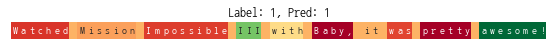

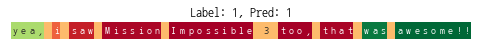

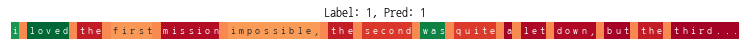

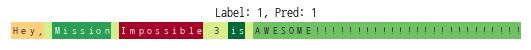

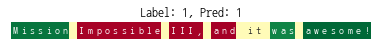

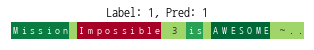

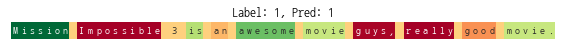

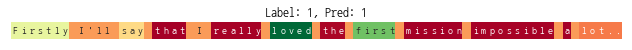

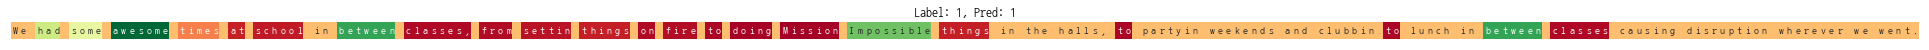

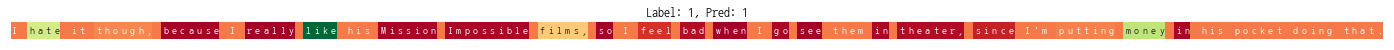

In [24]:
draw_sentence(np.arange(500, 510))